<a href="https://colab.research.google.com/github/sungjindo/NLP/blob/main/nsmc_binary_classification_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Init**

In [ ]:
!pip install transformers
!pip install --upgrade keras
!pip install --upgrade tensorflow

     |████████████████████████████████| 4.0 MB 6.3 MB/s 
     |████████████████████████████████| 895 kB 48.4 MB/s 
     |████████████████████████████████| 77 kB 4.0 MB/s 
     |████████████████████████████████| 596 kB 13.7 MB/s 
     |████████████████████████████████| 6.6 MB 48.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 462 kB 8.0 MB/s 


In [ ]:
import os
import torch
import numpy as np
import pandas as pd

from transformers import Trainer, TrainingArguments
from transformers import ElectraForSequenceClassification, ElectraTokenizer
from transformers import BertForSequenceClassification, BertTokenizerFast

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import seaborn as sn

# NSMC (Naver sentiment movie corpus)

https://github.com/e9t/nsmc

## Data description

- Each file is consisted of three columns: id, document, label
    - id: The review id, provieded by Naver
    - document: The actual review
    - label: The sentiment class of the review. (0: negative, 1: positive)
- Columns are delimited with tabs (i.e., .tsv format; but the file extension is .txt for easy access for novices)
    - 200K reviews in total
    - ratings.txt: All 200K reviews
    - ratings_test.txt: 50K reviews held out for testing
    - ratings_train.txt: 150K reviews for training
- All reviews are shorter than 140 characters
- Each sentiment class is sampled equally (i.e., random guess yields 50% accuracy)
- 100K negative reviews (originally reviews of ratings 1-4)
- 100K positive reviews (originally reviews of ratings 9-10)
- Neutral reviews (originally reviews of ratings 5-8) are excluded

## Basic Procedure for NLP using Transformers

1. Load Transformer Model & Tokenizer
2. Load & Convert Data
3. Set Parameters
4. Train
5. Evaluate

In [ ]:
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 22.22 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [ ]:
!head nsmc/ratings_train.txt

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의 긴장감을 제대로 살려내지못했다.	0
9443947	별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네	0
7156791	액션이 없는데도 재미 있는 몇안되는 영화	1


## 1. Load Transformer Model & Tokenizer

In [ ]:
#MBERT
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')
# model = BertForSequenceClassification.from_pretrained('mbert.nsmc')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')

#KoELECTRA
#https://github.com/monologg/KoELECTRA
# model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-discriminator", nun_label=5)
# tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-discriminator")

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

In [ ]:
a = tokenizer.tokenize('너무너무 좋다')

In [ ]:
a

['너', '##무', '##너', '##무', '좋', '##다']

In [ ]:
b=tokenizer.convert_tokens_to_ids(a)

In [ ]:
tokenizer.decode(b)

'너무너무 좋다'

In [ ]:
tokenizer.vocab
# vocab.txt

{'വി': 80054,
 '##ntaa': 103330,
 '##rapie': 96636,
 '##悬': 113638,
 '##jući': 37316,
 'consisting': 34343,
 'remainder': 50308,
 '##cit': 40167,
 'Nachbargemeinden': 71311,
 'sía': 103627,
 'Turing': 73162,
 'का': 11081,
 'চ': 953,
 '##traße': 43968,
 'indígenas': 49856,
 '##oline': 96541,
 'destacar': 32135,
 'kesällä': 100866,
 'Formosa': 88346,
 '최': 9764,
 'Chu': 31518,
 '##ows': 72945,
 '##야': 21711,
 'жолу': 94100,
 '##翠': 116210,
 '##搗': 113966,
 '##ỏ': 36091,
 '##рке': 91465,
 '##طر': 48227,
 'складае': 49019,
 'wiek': 105437,
 '##кей': 99832,
 '##ματος': 25477,
 'Catálogo': 108990,
 'Ginger': 90623,
 'Sabbath': 59011,
 'া': 981,
 '##ことも': 42675,
 'widespread': 48675,
 'prit': 67998,
 'olunmuşdur': 54550,
 'McCartney': 30638,
 '봉': 9362,
 'department': 21079,
 '##ומית': 58731,
 '##рката': 94969,
 '##creen': 101409,
 '##針': 117681,
 '##פועל': 106725,
 'アフリカ': 87842,
 '##ufe': 47977,
 '##ziny': 59418,
 'publiceerde': 101406,
 'mohl': 73283,
 'psychologie': 94030,
 '84433': 73634

In [ ]:
#Test Tokenizer
print(tokenizer.tokenize('故 김대중 前 대통령'))
print(tokenizer.tokenize('너무너무 재밌다'))
print(tokenizer('너무너무 재밌다')) # [CLS] 너무너무 재밌다 [SEP]

['故', '김', '##대', '##중', '前', '대통령']
['너', '##무', '##너', '##무', '[UNK]']
{'input_ids': [101, 9004, 32537, 70162, 32537, 100, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


## 2. Load & Convert Dataset

In [ ]:
#Load and Convert Data
test_dataset = pd.read_csv('nsmc/ratings_test.txt', sep='\t', quoting=3) # quoting=3: 큰따옴표 무시
train_dataset = pd.read_csv('nsmc/ratings_train.txt', sep='\t', quoting=3)

print(len(train_dataset), len(test_dataset))

150000 50000


In [ ]:
train_dataset.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
train_dataset=train_dataset[:10000]
test_dataset=test_dataset[:2000]

In [ ]:
lens = []
for doc in train_dataset['document']:
  lens.append(len(tokenizer.tokenize(doc)))
print(max(lens), sum(lens)/len(lens), min(lens))

128 24.4602 1


In [ ]:
train_dataset.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
intputs = tokenizer(sentence, return_tensors='pt')
# pt는 파이토치

In [ ]:
inputs

In [ ]:
inputs = {k:v.t('cuda') for k, v in inputs.items()}

In [ ]:
outputs = model(**inputs)s

In [ ]:
torch.argmax(outputs.logits, -1)

In [ ]:
#Make Dataset Class
class nsmc_data(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer):
        super().__init__()
        self.label = torch.tensor(dataset['label']).long()
        features = tokenizer([str(x) for x in dataset.document], padding=True, truncation=True,
                             max_length=128)
        # max_length파악 어디서..? 트레이닝 배치사이즈 맥스렝스에서 oom문제 해결
        self.input = torch.tensor(features['input_ids'])
        self.mask = torch.tensor(features['attention_mask'])
    
    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        return {'input_ids': self.input[index], 'attention_mask': self.mask[index], 'label':self.label[index]}

In [ ]:
train_data = nsmc_data(train_dataset, tokenizer)
test_data = nsmc_data(test_dataset, tokenizer)

In [ ]:
print(len(train_data))
print(len(test_data))

10000
2000


In [ ]:
train_data[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([   101,   9519,   9074, 119005,    119,    119,   9708, 119235,   9715,
         119230,  16439,  77884,  48549,   9284,  22333,  12692,    102,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,   

In [ ]:
# check
train_dataset.iloc[0]

id                      9976970
document    아 더빙.. 진짜 짜증나네요 목소리
label                         0
Name: 0, dtype: object

In [ ]:
tokenizer.decode(train_data[0]['input_ids'])

'[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

## 3. Set Parameters

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

  # 'micro': 각 샘플이나 예측에 동일한 가중치를 부여하고자 할 때 (accuracy와 비슷)
  # 'macro': 모든 클래스에 동일한 가중치를 부여 
  # 'weighted': 각 레이블이 불균형할 때 weight를 주어 계산. precision과 recall의 합이 아닌 F-score를 야기할 수 있음.
  # https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#989c



    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
#Trainer
#Hyper parameters
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3, 
    per_device_train_batch_size=64, # decrease batch size to avoid OOM error
    per_device_eval_batch_size=128, 

    warmup_steps=500,
    save_steps=2000,
    
    logging_dir='./logs',

    # learning_rate=2e-5,
    weight_decay=0.01,

    # evaluation_strategy="steps",
    # load_best_model_at_end = True
    # metric_for_best_model="accuracy",
    # dataloader_pin_memory=False, 
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=test_data
)

## 4.  Train Model

In [ ]:
#Train Model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 150000
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 7032


Step,Training Loss


Step,Training Loss
500,0.516400
1000,0.398700
1500,0.370300
2000,0.355600
2500,0.325900
3000,0.293700
3500,0.287300
4000,0.278200
4500,0.277000
5000,0.229600


Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-4000
Configuration saved in ./results/checkpoint-4000/config.json
Model weights saved in ./results/checkpoint-4000/pytorch_model.bin


KeyboardInterrupt: ignored

## 5. Evaluate Model

In [ ]:
#Evaluate Model
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 128


{'epoch': 3.0,
 'eval_accuracy': 0.8075,
 'eval_f1': 0.8223350253807106,
 'eval_loss': 0.4463633894920349,
 'eval_precision': 0.781578947368421,
 'eval_recall': 0.8675754625121713,
 'eval_runtime': 22.63,
 'eval_samples_per_second': 88.378,
 'eval_steps_per_second': 0.707}

In [ ]:
# 나중을 위해 모델 저장
trainer.save_model('mbert.nsmc')

Saving model checkpoint to mbert.nsmc
Configuration saved in mbert.nsmc/config.json
Model weights saved in mbert.nsmc/pytorch_model.bin


In [ ]:
saved_model = BertForSequenceClassification.from_pretrained('mbert.nsmc')

loading configuration file mbert.nsmc/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}

loading weights file mbert.nsm

In [ ]:
# trainer.model.save_pretrained~밑에꺼랑 같음

In [ ]:
tokenizer.save_pretrained('mbert.nsmc')

### Results

**MBert**

`train_batch_size=16`

    {'eval_loss': 0.3571779727935791,
     'eval_accuracy': 0.8459,
     'eval_f1': 0.8457364806695096,
     'eval_precision': 0.852547025106967,
     'eval_recall': 0.8390338855122552,
     'epoch': 1.0}

`train_batch_size=32`

    {'eval_loss': 0.32168760895729065,
     'eval_accuracy': 0.86206,
     'eval_f1': 0.862497258717279,
     'eval_precision': 0.8657248058912991,
     'eval_recall': 0.8592936876812458,
     'epoch': 1.0}


**Koelectra**

`train_batch_size=16`

    {'eval_loss': 0.25483399629592896,
     'eval_accuracy': 0.90056,
     'eval_f1': 0.9010035043007327,
     'eval_precision': 0.9031974771466209,
     'eval_recall': 0.8988201644619235,
     'epoch': 1.0}

`train_batch_size=32`

    {'eval_loss': 0.24420708417892456,
     'eval_accuracy': 0.90184,
     'eval_f1': 0.902707846013559,
     'eval_precision': 0.9009219324971314,
     'eval_recall': 0.9045008540896993,
     'epoch': 1.0}

`train_batch_size=128`

    {'eval_loss': 0.25068381428718567,
     'eval_accuracy': 0.89754,
     'eval_f1': 0.8987769457232617,
     'eval_precision': 0.8940954477553267,
     'eval_recall': 0.9035077265323959,
     'epoch': 1.0}


## Try KR-BERT

https://github.com/snunlp/KR-BERT

In [ ]:
#KR-BERT
model2 = BertForSequenceClassification.from_pretrained('snunlp/KR-BERT-char16424')
# model2 = BertForSequenceClassification.from_pretrained('krbert.nsmc')
tokenizer2 = BertTokenizerFast.from_pretrained('snunlp/KR-BERT-char16424')

Some weights of the model checkpoint at snunlp/KR-BERT-char16424 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkp

In [ ]:
#Test Tokenizer
print(tokenizer2.tokenize('故 김대중 前 대통령'))
print(tokenizer2.tokenize('너무너무 재밌다'))
print(tokenizer2('너무너무 재밌다'))

['[UNK]', '김대중', '[UNK]', '대통령']
['너무', '##너', '##무', '재', '##밌', '##다']
{'input_ids': [2, 1006, 917, 220, 249, 9891, 31, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
#Load and Convert Data
test_dataset2 = pd.read_csv('nsmc/ratings_test.txt', sep='\t', quoting=3)
train_data2 = nsmc_data(pd.read_csv('nsmc/ratings_train.txt', sep='\t', quoting=3), tokenizer2)
test_data2 = nsmc_data(test_dataset2, tokenizer2)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
#Trainer
training_args2 = TrainingArguments(
    output_dir='./results_krbert',
    num_train_epochs=3, 
    per_device_train_batch_size=64, # decrease batch size to avoid OOM error
    per_device_eval_batch_size=128,
    warmup_steps=500,
    weight_decay=0.01,
    save_steps=2000,
    logging_dir='./logs2',
)

In [ ]:
trainer2 = Trainer(
    model=model2,
    args=training_args2,
    compute_metrics=compute_metrics,
    train_dataset=train_data2,
    eval_dataset=test_data2
)

In [ ]:
#Train Model
trainer2.train()

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.376700
1000,0.240800
1500,0.176700


/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

TrainOutput(global_step=1758, training_loss=0.24746358218317824, metrics={'train_runtime': 1623.7577, 'train_samples_per_second': 1.083, 'total_flos': 3.78249074676e+16, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 13477691, 'init_mem_gpu_alloc_delta': 395032064, 'init_mem_cpu_peaked_delta': 18282, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 53704177, 'train_mem_gpu_alloc_delta': 1216498176, 'train_mem_cpu_peaked_delta': 6799452, 'train_mem_gpu_peaked_delta': 8159280640})

In [ ]:
#Evaluate Model
trainer2.evaluate()

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

{'eval_loss': 0.27458661794662476,
 'eval_accuracy': 0.89926,
 'eval_f1': 0.9000258023539686,
 'eval_precision': 0.8993653312177707,
 'eval_recall': 0.900687244269654,
 'eval_runtime': 48.2469,
 'eval_samples_per_second': 1036.336,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': 964272,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 2458142,
 'eval_mem_gpu_peaked_delta': 579230720}

In [ ]:
trainer2.save_model('krbert.nsmc')

## Error Analysis

`predict(test_dataset: tensorflow.python.data.ops.dataset_ops.DatasetV2)` 

    Run prediction and returns predictions and potential metrics.

    Depending on the dataset and your use case, your test dataset may contain labels. In that case, this method will also return metrics, like in evaluate().

    Parameters
    test_dataset (Dataset) – Dataset to run the predictions on. The dataset should yield tuples of (features, labels) where features is a dict of input features and labels is the labels. If labels is a tensor, the loss is calculated by the model by calling model(features, labels=labels). If labels is a dict, such as when using a QuestionAnswering head model with multiple targets, the loss is instead calculated by calling model(features, **labels)

    Returns: NamedTuple A namedtuple with the following keys:

    predictions (np.ndarray): The predictions on test_dataset.

    label_ids (np.ndarray, optional): The labels (if the dataset contained some).

    metrics (Dict[str, float], optional): The potential dictionary of metrics (if the dataset contained labels).`

https://huggingface.co/transformers/main_classes/trainer.html#transformers.Trainer.evaluate

In [ ]:
#Get Predictions as Array
preds = trainer2.predict(test_data2)
print(preds)

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/sana/.local/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were

PredictionOutput(predictions=array([[-2.560289 ,  2.5997834],
       [-1.020877 ,  1.4086087],
       [ 0.6445138, -0.4847369],
       ...,
       [ 1.0811409, -1.1007564],
       [ 3.9823005, -3.1170654],
       [ 2.0084088, -1.1697395]], dtype=float32), label_ids=array([1, 0, 0, ..., 0, 0, 0]), metrics={'eval_loss': 0.27458661794662476, 'eval_accuracy': 0.89926, 'eval_f1': 0.9000258023539686, 'eval_precision': 0.8993653312177707, 'eval_recall': 0.900687244269654, 'eval_runtime': 47.9634, 'eval_samples_per_second': 1042.462, 'test_mem_cpu_alloc_delta': 896567, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 2517369, 'test_mem_gpu_peaked_delta': 579230720})


In [ ]:
#Argmax Softmax Values
predictions = np.argmax(preds[0], axis=1)
labels = preds[1]
print(predictions)
print(labels)

print(len(predictions), len(labels))

[1 1 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
50000 50000


[Text(33,0.5,'Observed'),
 Text(0.5,15,'Predicted'),
 Text(0.5,1,'Confusion Matrix')]

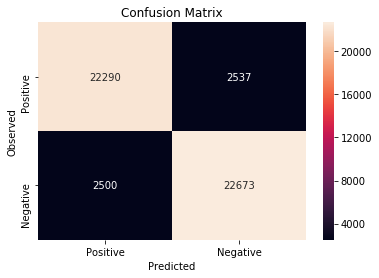

In [ ]:
#Confusion Matrix

cm = confusion_matrix(labels,predictions)
df_cm = pd.DataFrame(cm, index = ["Positive", "Negative"],
                  columns = ["Positive", "Negative"])
sn.heatmap(df_cm, annot=True, fmt=".0f").set(title="Confusion Matrix", xlabel="Predicted", ylabel="Observed",)

In [ ]:
# 원래 정답은 positive인데 negative로 잘못 예측한 경우
(labels == 1)&(predictions == 0)

array([False, False, False, ..., False, False, False])

In [ ]:
# False Negative
test_dataset2['document'][(labels == 1)&(predictions == 0)].sample(10)

28630                                   포스터공포영환줄알앗음
21675                     후드티입은 시간멈춰도움직이는사람은 어떻게된건지
20732                                           444
45626                                 데빌메이크라이의 성지순례
30505                               그녀가아니면누가저리완벽했을꼬
12984                            미친:: 절대안먹어 이제 살빼야지
31372    누구는 공감하고, 누구는 뜨끔하고, 누구는 불쾌하고, 어떤이는 무덤덤할...
47941                                        감자와 모유
9558                                  하다하다 이게 속편 ㅋㅋ
49545            이미 전설이 된 감독 자신의 서부극을 현대식으로 재탄생시키다.
Name: document, dtype: object

In [ ]:
# False Positive (원래 정답은 negative인데 positive로 잘못 예측한 경우)
test_dataset2['document'][(labels == 0)&(predictions == 1)].sample(10)

39291    처음의 한시간은 쓸데없는 부분이 많았고 너무 고전적인 결말이었는데 2002년에 봤다...
16431                                       우러러볼수록 낮아만 지네.
34450                                맨 인 블랙 리부트 '백 투 더 블랙'
15076                      한겨울에 느끼는 춘곤증이라니.. 사람 지치게 만드는 영화
39022               단편,독립영화라고 하지만 보는사람 입장에서 생각하고 만들었음 좋겠다.
24201                                    러시아여자가 제일 연기잘함ㅋㅋㅋ
21278                                                  멋지다
1267                                     미친듯이달려가서 액션놀이하네!~
48938                                                   ㅎㅎ
1723                                   nothing and nothing
Name: document, dtype: object